# Data Distributions 

## Setup

In [ ]:
import pickle
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba

import seaborn as sns

# import Utilities
import importlib
# importlib.reload(Utilities)

# import MLUtilities
# importlib.reload(MLUtilities)

from sklearn.pipeline import Pipeline


# from sklearn.preprocessing import StandardScaler, OrdinalEncoder, MinMaxScaler, PowerTransformer, RobustScaler
from sklearn.preprocessing import  MinMaxScaler
from sklearn.preprocessing import  OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import r2_score, classification_report, confusion_matrix, roc_auc_score, accuracy_score, balanced_accuracy_score, precision_score
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.ensemble import RandomForestClassifier


# from hyperopt.pyll import scope
# from hyperopt import fmin, tpe, hp, SparkTrials, Trials, STATUS_OK

from hyperopt import hp,Trials,fmin,tpe,STATUS_OK

import xgboost as xgb

from imblearn.over_sampling import SMOTENC

pd.set_option('display.max_columns', None)


plt.style.use('./CEIH.mplstyle')
color_dict = {0: to_rgba('#32C0D2', 1),
                1: to_rgba("#E0B165", 1),}

cmap_blended = sns.blend_palette(["#ADE6ED","#70D3E0","#32C0D2","#289AA8","#307078"], as_cmap=True)


# import math
def find_nearest(array,value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return array[idx-1],idx-1
    else:
        return array[idx],idx
    

    
OtherValues = {'TriageCategory_2':'Triage Category 2', 'SoBFlag': 'Shortness of Breath', 'TriageCategory_4':'Triage Category 4',
               'TriageCategory_1':'Triage Category 1', 'TriageCategory_5':'Triage Category 5', 'TriageCategory_3':'Triage Category 3',
             'FirstGCSScoreAdult':'Glasgow Coma Scale',
               'FirstUrinalysisBlood': 'Urinalysis Blood', 'IndigenousStatusDescription_Not Aboriginal-TSI':  'Non Indiginous',
               'IndigenousStatusDescription_Not Stated':  'Indiginous Status not stated', 'FirstUrinalysisLeukocytes':'Urinalysis Leukocytes',
               'FirstPulseRateBPM':'Pulse Rate', 'FirstRespiration':'Respiration Rate', 'FirstSpO2':'O2 Saturation (%)',  'Gender_Male':'Sex - Male',
               'FirstLevelofConsciousness':'Level of Consciousness', 'IndigenousStatusDescription_Aboriginal and TSI':'Aboriginal and TSI',
               'IndigenousStatusDescription_TSI':'TSI','Gender_Indeterminate':'Sex - Indeterminate', 'Gender_Unknown':'Sex - Unknown',
               'FirstO2Flow':'O2 Flow ','GENDERCODE_Male':'Sex - Male','GENDERCODE_Unknown':'Sex - Unknown',
               'GENDERCODE_Indeterminate':'Sex - Indeterminate'
               }


## Load data

In [3]:
Data_Storage_File = 'Data\ED_Presentations_{}_{}_Version_01.pkl'.format(2023,2024)
print(Data_Storage_File)


with open(Data_Storage_File, 'rb') as file:
    sepsis_df = pd.read_pickle(file)



Data\ED_Presentations_2023_2024_Version_01.pkl


In [79]:
sepsis_temp_df = sepsis_df.copy()

sepsis_temp_df.dropna(subset=['NUMBER_NOT_NULL'],inplace=True)
sepsis_temp_df.drop(sepsis_temp_df.loc[sepsis_df.AGEONADMIT>120].index,inplace=True)



AnalysisVariable =[ 
       'Pulse Rate (beats/min)',
       'Temperature (degrees C)', 
       'BP Systolic (mm Hg)',
       # 'BP Diastolic (mm Hg)', 
       'O2 Flow (L/min)', 
       'Sedation Score',
       # 'Resting Pain Score', 
       'Respiration (breaths/min)',
       # 'Pain: New/Unexpected', 
       'SpO2 (%)',
       'AGEONADMIT',
    #    'GENDERCODE',
       ]

for key in AnalysisVariable:
    sepsis_temp_df[key] = pd.to_numeric(sepsis_temp_df[key])

sepsis_temp_df['O2_Flow_Flag'] =  0
sepsis_temp_df.loc[sepsis_temp_df['O2 Flow (L/min)']>0,  'O2_Flow_Flag'] =  1

# sepsis_2023_df = sepsis_df.loc[sepsis_df.ADMITDTM.between('2023-01-01','2024-01-01')].copy()
# sepsis_2023_df = sepsis_2023_df.loc[sepsis_2023_df.AGEONADMIT<120].copy()
# sepsis_2023_df = sepsis_2023_df.loc[sepsis_2023_df.GENDERCODE!='Unknown'].copy()


In [152]:
sepsis_df.head()

,JOURNEY_ID,CLIENTGUID,VISITGUID,CHARTGUID,ADMITDTM,DISCHARGEDTM,AGEONADMIT,TRIAGE_CATEGORY,DISCHARGEDISPOSITION,HOSPITAL,FIRSTTRIAGEVALUE,GENDERCODE,RACECODE,DECEASEDDTM,PRIMARY_SEPSIS,ANY_SEPSIS,VISITGUID_IP,CHARTGUID_IP,ADMITDTM_IP,DISCHARGEDTM_IP,PRE_ADMITDTM,PRE_DISCHARGEDTM,ADMITDTM_IP,DISCHARGEDTM_IP,AGEONADMIT_IP,MORTALITY_INDICATOR,DISCHARGEDISPOSITION_IP,ALLCHARDIAGNOSIS,CURRENTLOCATION,IP_ED_Overlap,HOSPITAL_IP,VITALS_SEQ_BY_VISIT,NUMBER_NOT_NULL,AUTHOREDDTM,Purple zone,Red zone,Yellow zone,Pulse Rate (beats/min),Temperature (degrees C),BP Systolic (mm Hg),BP Diastolic (mm Hg),O2 Flow (L/min),Sedation Score,Resting Pain Score,Respiration (breaths/min),Pain: New/Unexpected,SpO2 (%),GCS Score,ICU_HOURS,AGERANGE_ON_ADMIT2,IndiginousFlag,number_of_NaNs,qSOFA,White Cell Count,Lactate,qSIRS,qSIRS_Severe
0,22454301634741464539-117,20674400200,2371812900270,1708559100170,2023-05-24 10:28:00+00:00,2023-05-24 13:00:00+00:00,50,4,ED02 Admit as Inpatient,NHS,4,Male,Not Aboriginal-TSI,NaT,0,0,2371862400270,1708559100170,2023-05-24 12:38:00+00:00,2023-05-25 23:42:00+00:00,2023-05-24 10:28:00+00:00,2023-05-24 13:00:00+00:00,2023-05-24 12:38:00+00:00,2023-05-25 23:42:00+00:00,50,Didnt Die,IP Home,S602 T793 B956 W22 Y929 U739 Z8643 U862 U833,NHS-COLL-42-A,2082.0,NHS,1,4,2023-05-24 10:36:00+00:00,0,0,1,81,None,141,80,None,0,<NA>,22,None,98,15,NaN,35 - 64,0,1,1.0,9.41,NaN,NaN,NaN
1,32322171454741464540-101,305422700200,2357888800270,1700353700170,2023-05-15 11:25:00+00:00,2023-05-15 15:53:00+00:00,48,2,ED01 Discharged Home,FMC,2,Male,Not Aboriginal-TSI,NaT,0,0,<NA>,<NA>,NaT,NaT,NaT,NaT,NaT,NaT,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,1,5,2023-05-15 11:42:00+00:00,<NA>,<NA>,<NA>,64,36.4,105,72,0,<NA>,<NA>,18,None,98,15,NaN,35 - 64,0,0,0.0,NaN,NaN,1.0,0.0
2,94649201634741464539-104,92869300200,2362264900270,1702873500170,2023-05-18 01:11:00+00:00,2023-05-18 05:23:00+00:00,54,2,ED01 Discharged Home,RAH,2,Female,Not Aboriginal-TSI,NaT,0,0,<NA>,<NA>,NaT,NaT,NaT,NaT,NaT,NaT,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,1,4,2023-05-18 01:39:00+00:00,<NA>,<NA>,<NA>,79,None,138,98,None,<NA>,<NA>,18,None,100,15,NaN,35 - 64,0,1,0.0,6.43,NaN,NaN,NaN
3,17481101634741464539-106,15701200200,2361766700270,1702599800170,2023-05-17 12:18:00+00:00,2023-05-17 16:07:00+00:00,22,2,ED02 Admit as Inpatient,FMC,2,Male,Not Aboriginal-TSI,NaT,0,0,2361819900270,1702599800170,2023-05-17 15:59:00+00:00,2023-06-14 00:59:00+00:00,2023-05-17 12:18:00+00:00,2023-05-17 16:07:00+00:00,2023-05-17 15:59:00+00:00,2023-06-14 00:59:00+00:00,22,Didnt Die,IP Home,J690 B965 W78 Y9209 E876 K117 U833 U794,FMC-4A-20-20,39412.0,FMC,1,5,2023-05-17 12:34:00+00:00,0,2,0,131,37,126,86,None,<NA>,<NA>,30,None,95,10,613.0,<35,0,0,2.0,7.52,1.8,1.0,0.0
4,77505903434741464538-102,7572600200,2365833300270,1705094400170,2023-05-20 12:31:00+00:00,2023-05-20 17:06:00+00:00,68,3,ED01 Discharged Home,FMC,3,Female,Not Aboriginal-TSI,NaT,0,0,<NA>,<NA>,NaT,NaT,NaT,NaT,NaT,NaT,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,1,5,2023-05-20 13:46:00+00:00,0,0,0,98,35.9,154,65,None,0,3,18,no,99,15,NaN,65 - 84,0,0,0.0,NaN,NaN,1.0,0.0


In [80]:
DiagnosisString = 'ANY_SEPSIS'

AnalysisVariable =[ 
       'Pulse Rate (beats/min)',
    #    'Temperature (degrees C)', 
    #    'BP Systolic (mm Hg)',
    #    # 'BP Diastolic (mm Hg)', 
    #    'O2 Flow (L/min)', 
    #    'Sedation Score',
    #    # 'Resting Pain Score', 
    #    'Respiration (breaths/min)',
    #    # 'Pain: New/Unexpected', 
    #    'SpO2 (%)',
    #    'AGEONADMIT',
    #    'GENDERCODE',
       ]

In [ ]:

plotSettings = {
        #  ( bins, xmin, xmax, log/linear)
        'AGEONADMISSION':(45,19.5,109.5,'linear','Age (y)', False, 0,0),
        
        'BP Systolic (mm Hg)': (50,50,300,'log', 'BP Systolic [mm Hg]',True, 100,170 ),
        'Temperature (degrees C)':(50,26,42,'log', r"Temperature [$^\circ$C]", True,35.5,38.1),
        
        'FirstPainAssessment': (11,-0.5,10.5,'log','Pain Assessment', False, 8,10),
        'FirstBPDiastolic': (50,0,200,'log', 'BP Diastolic [mm Hg]', False,0,0),
        'FirstEstimatedGlomerularFiltrationRate': (50,0,100,'log',r"Estimated Glomerular Filtration Rate [mL/min/1.73m$^{2}$]", True, 60, 100),
        'FirstCreatinine': (50,0,800,'log',r"Creatinine - Serum [$\mu$mol/L]", True, 45, 110),
        'FirstAlbumin': (60,0,60,'log','Albumin  Level [g/L]', True, 30, 48),
        'FirstTotalBilirubin': (60,0,100,'log',r"Total Bilirubin Level [$\mu$mol/L]", True, 2, 24 ),
        'FirstAlkalinePhosphatase': (60,0,800,'log','Alkaline Phosphatase Level [U/L]',True, 30,110),
        'FirstAlanineAminotransferase': (60,0,700,'log','Alanine Aminotransferase Level [U/L]', True,0,55),
        'FirstAspartateAminotransferase': (60,0,700,'log','Aspartate Aminotransferase Level [U/L]', True, 0,45),
        'FirstGammaGlutamylTransferase': (60,0,700,'log','Gamma Glutamyl Transferase Level [U/L]', True, 0, 60),
        'FirstLactateDehydrogenase': (60,0,1200,'log','Lactate Dehydrogenase [U/L]', True, 120, 250),
        'FirstHaemoglobin': (50,10, 220,'log','Haemoglobin [g/L]', True, 115, 175),
        'FirstWhiteCellCount': (50,0, 50,'log',r"White Cell Count [$\times 10^{9}$/L]",True, 4,11),
        'FirstPlateletCount': (50,0, 1000,'log',r"Platelet Count [$\times 10^{9}$/L]",True,150,500),
        'FirstNeutrophils': (50,0, 50,'log',r"Absolute Neutrophil Count [$\times 10^{9}$/L]",True,1.80,7.50),
        'FirstDDimer': (40,0, 20,'log',r"D-Dimer [mg/L]",True,0,0.79),
        'FirstCreactiveprotein': (50,0, 600,'log',r"C-Reactive Protein [mg/L]",True, 0,8),
        'FirstTroponinT': (50,0, 600,'log',r"Troponin T Level [mg/L]",True,0,16),
        'FirstNTproBNP': (50,0, 40000,'log',r"NT-pro Brain Natriuretic Peptide [mg/L]",True,0,124),
        
        'FirstAnionGapVenous': (50,0, 50,'log',r"Anion Gap Venous [mmol/L]", True, 7, 17),
        'FirstAnionGapArterial': (50,0, 50,'log',r"Anion Gap Arterial [mmol/L]",  True, 7, 17),
        'FirstBaseExcessVenous': (50,-30, 30,'log',r"Base Excess Venous [mmol/L]", True, -3, 3),
        'FirstBaseExcessArterial': (50,-30, 30,'log',r"Base Excess Arterial [mmol/L]", True, -3, 3),
        'FirstBilirubinVenous': (60,0, 60,'log',r"Bilirubin Venous [$\mu$mol/L]", True, 2,24),
        'FirstBilirubinArterial': (60,0, 60,'log',r"Bilirubin Arterial [$\mu$mol/L]", True, 2,24),
        'FirstCarboxyhaemoglobinVenous': (50,0, 20,'log',r"Carboxyhaemoglobin Venous [%]", True, 0.3, 1.8),
        'FirstCarboxyhaemoglobinArterial': (50,0, 20,'log',r"Carboxyhaemoglobin Arterial [%]", True, 0.3, 1.8),
        'FirstChlorideDirectVenous': (50,50, 150,'log',r"Chloride Direct Venous [mmol/L]",False, 100,109),
        'FirstChlorideDirectArterial': (50,50, 150,'log',r"Chloride Direct Arterial [mmol/L]", True, 100,109),
        'FirstCreatinineVenous':(50,0,500,'log',r"Creatinine Venous [$\mu$mol/L]", True, 50, 120),
        'FirstCreatinineArterial':(50,0,500,'log',r"Creatinine Arterial [$\mu$mol/L]", True, 50,120),
        'FirstGlucoseVenous':(50,0,30,'log',r"Glucose  Venous [mmol/L]", False,0,0),
        'FirstGlucoseArterial':(50,0,30,'log',r"Glucose  Arterial [mmol/L]", True,2.6,5.6),
        'FirstIonised Calcium Venous':(50,0,2,'log',r"Ionised Calcium Venous [mmol/L]", True, 1.1, 1.3),
        'FirstIonised Calcium Arterial':(50,0,2,'log',r"Ionised Calcium Arterial [mmol/L]", True, 1.1, 1.3),
        'FirstLactateVenous':(50,0,30,'log',r"Lactate Venous [mmol/L]", True, 0.2, 2.0),
        'FirstLactateArterial':(50,0,30,'log',r"Lactate Arterial [mmol/L]", True, 0.2, 2.0),
        'FirstMethaemoglobinVenous': (20,0, 3,'log',r"Methaemoglobin Venous [%]", True, 0.4, 1.2),
        'FirstMethaemoglobinArterial': (20,0, 3,'log',r"Methaemoglobin Arterial [%]", True, 0.2,0.6),
        'FirstOxygenSaturationVenous': (50,0, 100,'log',r"Oxygen Saturation Venous [%]", False, 0,0),
        'FirstOxygenSaturationArterial': (50,0, 100,'log',r"Oxygen Saturation Arterial [%]", True,95, 99),
        'FirstOxyhaemoglobinVenous': (50,0, 100,'log',r"Oxyhaemoglobin Venous [%]", False, 0,0),
        'FirstOxyhaemoglobinArterial': (50,0, 100,'log',r"Oxyhaemoglobin Arterial [%]", False, 0,0),
        'FirstReducedHaemoglobinVenous': (50,0, 100,'log',r"Reduced Haemoglobin Venous [%]", False, 0,0),
        'FirstReducedHaemoglobinArterial': (50,0, 100,'log',r"Reduced Haemoglobin Arterial [%]", False, 0,0),
        'FirstTotalHaemoglobinVenous': (50,10, 220,'log','Total Haemoglobin Venous [g/L]', True, 115,180),
        'FirstTotalHaemoglobinArterial': (50,10, 220,'log','Total Haemoglobin Arterial [g/L]', True, 115,180), 
        'FirstpCO2Venous': (50,0,150,'log', 'pCO2 Venous [mm Hg]', True,41,51),
        'FirstpCO2Arterial': (50,0,150,'log', 'pCO2 Arterial [mm Hg]', True, 35, 45 ),
        'FirstpO2Venous': (50,0,200,'log', 'pO2 Venous [mm Hg]', True, 25,40),
        'FirstpO2Arterial': (50,0,200,'log', 'pO2 Arterial [mm Hg]', True,67, 108),
        'FirstpHVenous': (50,6.8,7.8,'log', 'pH Venous', True, 7.32,7.42),
        'FirstpHArterial': (50,6.8,7.8,'log', 'pH Arterial', True, 7.36, 7.44),
        'FirstPotassiumDirectVenous':(50,0,10,'log',r"Potassium Direct Venous [mmol/L]", False, 0,0),
        'FirstPotassiumDirectArterial':(50,0,10,'log',r"Potassium Direct Arterial [mmol/L]", True, 3.1, 4.2),
        'FirstSodiumDirectVenous':(50,100,180,'log',r"Sodium Direct Venous [mmol/L]", False, 0,0),
        'FirstSodiumDirectArterial':(50,100,180,'log',r"Sodium Direct Arterial [mmol/L]", True, 137, 145),
        

         'FirstLevelofConsciousness':(4,-0.5,3.5,'log',"Level of Consciousness",True,-0.5,2),
        'FirstGCSScoreAdult':(16,-0.5,15.5,'log','Glasgow Coma Scale',False,0,0)
        
        }



In [156]:
# plotSettings = {
#         #  ( bins, xmin, xmax, log/linear)
#         'AGEONADMIT':(45,19.5,109.5,'linear','Age (y)', False, 0,0),
        
#         'BP Systolic (mm Hg)': (50,50,300,'log', 'BP Systolic [mm Hg]',True, 100,170 ),
#         'Temperature (degrees C)':(50,26,42,'log', r"Temperature [$^\circ$C]", True,35.5,38.1),
#         'Pulse Rate (beats/min)':(50,0,250,'log','Pulse Rate [beats/min]' ,True,60,100),
#         'O2 Flow (L/min)':(20,0,20,'log',r"O$_{2}$ Flow", True,0,5),
#         'O2_Flow_Flag':(2,-0.5,1.5,'log',r"O$_{2}$ Flow Flag",False,0,0),
#         'Respiration (breaths/min)':(25,0,50,'log','Respiration Rate [breath/min]',True,10,21),
#         'SpO2 (%)':(20,80,100,'log',r"O$_{2}$ Saturation [%]",True,94,100),
#         'Sedation Score':(4,-0.5,3.5,'log',"Sedation Score",True,-0.5,1.5),


        

# }


# DiagnosisString = 'ANY_SEPSIS'

# PlotString = 'Sepsis Pathway'

# AnalysisVariable =[ 
#        'Pulse Rate (beats/min)',
#    #     'Temperature (degrees C)', 
#    #     'BP Systolic (mm Hg)',
#    #  #    # 'BP Diastolic (mm Hg)', 
#    #    #  'O2 Flow (L/min)', 
#    #     'O2_Flow_Flag',
#        'Sedation Score',
#    #  #    # 'Resting Pain Score', 
#    #     'Respiration (breaths/min)',
#    #     # 'Pain: New/Unexpected', 
#    #     'SpO2 (%)',
#    #    #  'AGEONADMIT',
#    #  #    'GENDERCODE',
#        ]

# for i in range(len(AnalysisVariable)):
#    #  print(i)
#    item = AnalysisVariable[i]
#    plotSettingValues = plotSettings[item]
    
#    fig, ax = plt.subplots(figsize=(7, 7))
#    fig.tight_layout() 
#    ax.grid(False)


#    hist = sns.histplot(data=sepsis_temp_df.loc[~sepsis_temp_df[item].isna()], x=item,  stat= 'probability', 
#                         palette={1: to_rgba("#32C0D2", 1), 0: to_rgba("#E0B165",1),}, hue=DiagnosisString, 
#                         alpha=0.5, common_norm=False,
#                         bins=plotSettingValues[0], 
#                         label=plotSettingValues[4] , #  color_dict,
#                     binrange=(plotSettingValues[1], plotSettingValues[2]), 
#     )

#    if plotSettingValues[5]:
#       x1 = plotSettingValues[6]
#       x2 = plotSettingValues[7]
#       y = np.arange(0,ax.get_ylim()[1],0.01)
#       ax.fill_betweenx(y,x1,x2, facecolor='none', edgecolor='black', hatch='xx',alpha=0.5, label='Normal Results')

#    handles, labels  =  ax.get_legend_handles_labels()
#    print(labels)
#    if plotSettingValues[5]:
#       ax.legend(handles, [ 'Normal Results', '{} Cases'.format(PlotString), 'Other Cases' ], loc='best',  title='ED - Pathway',alignment='center')
#    else: 
#       ax.legend(handles, ['{} Cases'.format(PlotString), 'Other Cases' ],  loc='best',  title='ED - Pathway',alignment='center')
            
#    hist.plot()
#    ax.set(xlabel=plotSettingValues[4])
#    plt.yscale(plotSettingValues[3])





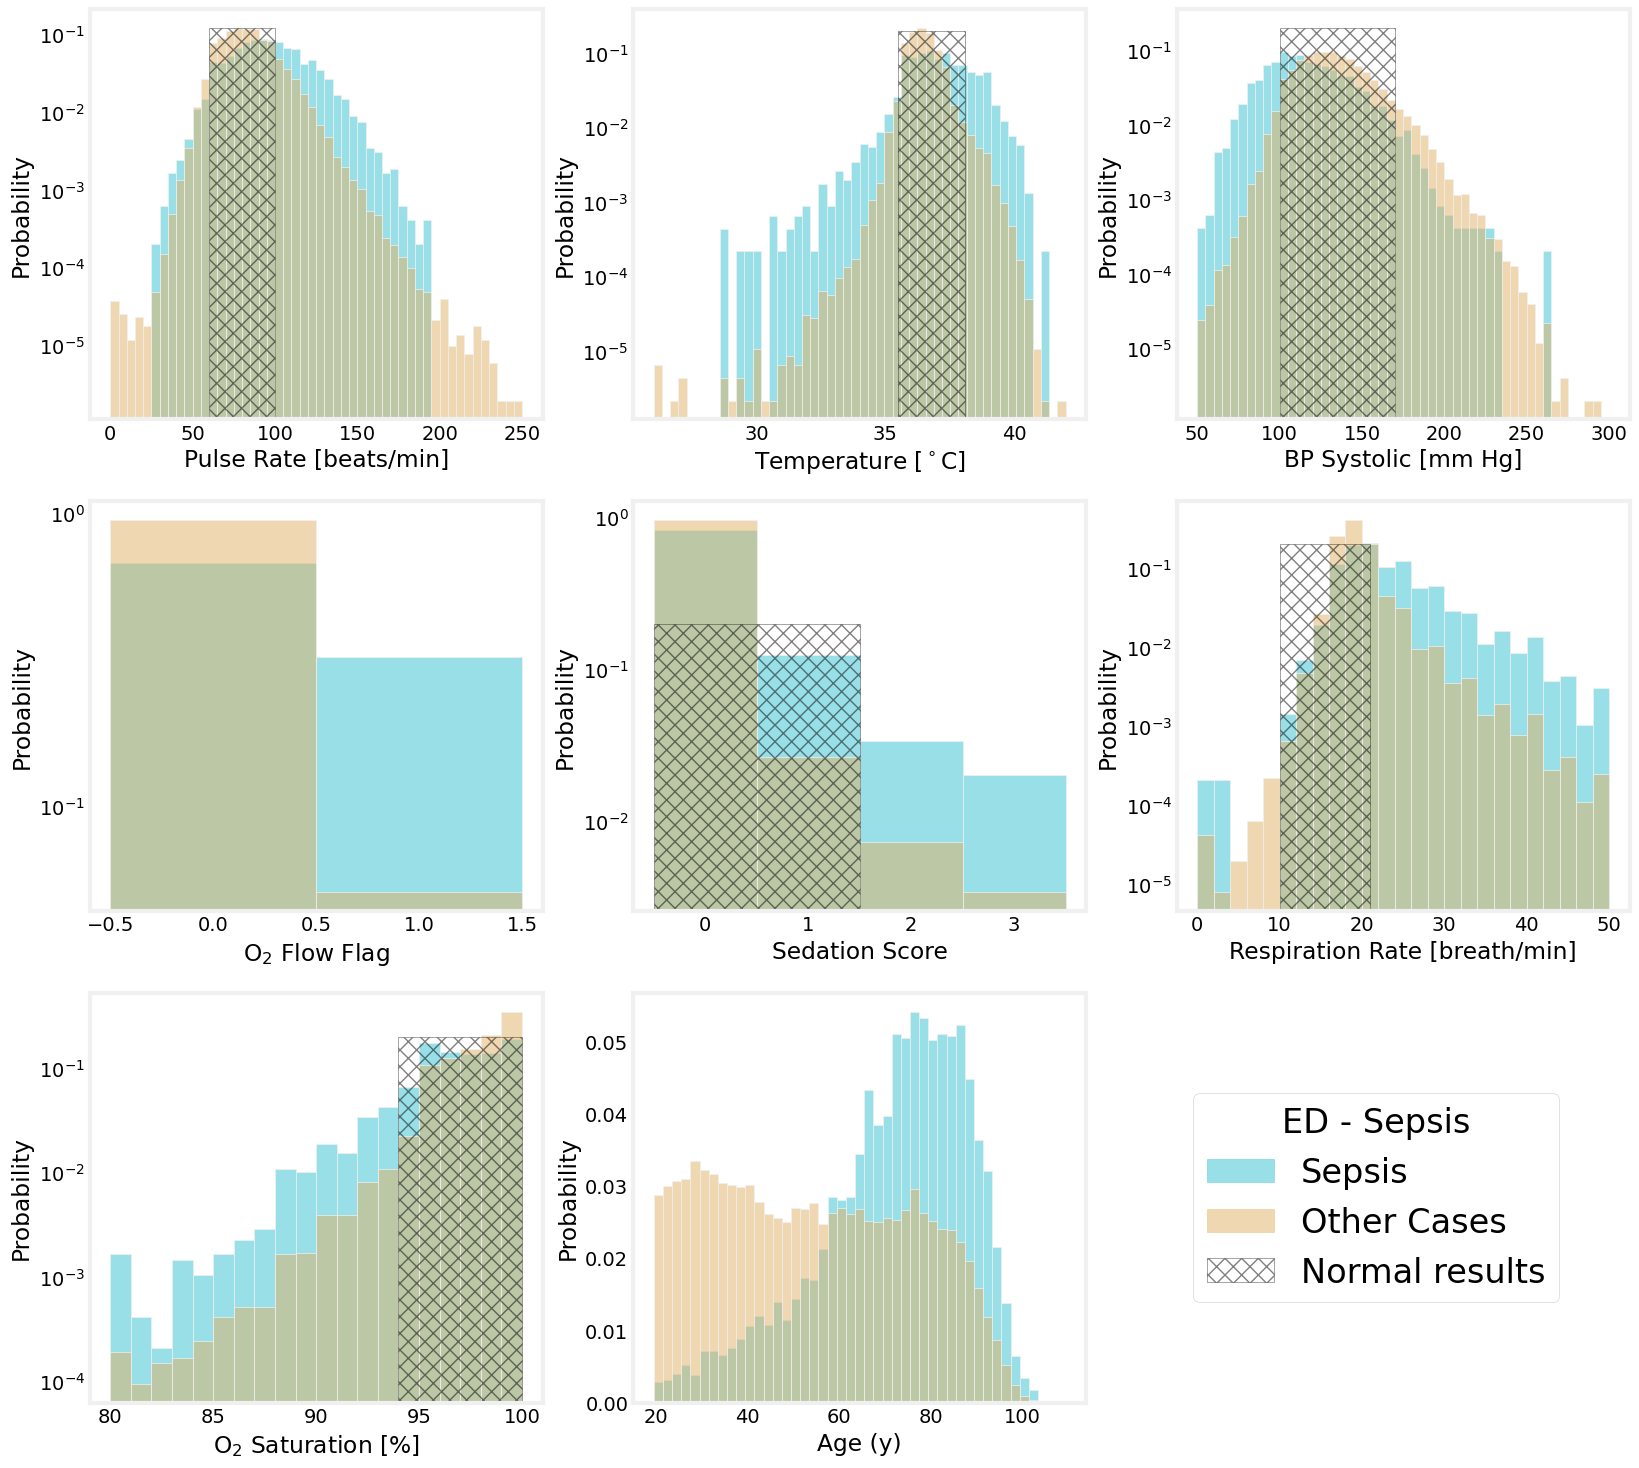

In [157]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(5.9*3, 8.6*2))

import matplotlib.patches as mpatches
vars =[ 
       ('Pulse Rate (beats/min)',0,0),
       ('Temperature (degrees C)',0,1), 
       ('BP Systolic (mm Hg)',0,2),
   #  #    # 'BP Diastolic (mm Hg)', 
   #    #  'O2 Flow (L/min)', 
       ('O2_Flow_Flag',1,0),
       ('Sedation Score',1,1),
   #  #    # 'Resting Pain Score', 
       ('Respiration (breaths/min)',1,2),
   #     # 'Pain: New/Unexpected', 
       ('SpO2 (%)',2,0),
       ('AGEONADMIT',2,1)
   #  #    'GENDERCODE',
       ]


for v in vars:
    item = v[0]
    axis = axs[v[1],v[2]]
    # item = 'Pulse Rate (beats/min)'
    plotSettingValues = plotSettings[item]






    hist = sns.histplot(data=sepsis_temp_df.loc[~sepsis_temp_df[item].isna()], x=item,  stat= 'probability', 
                    palette={1: to_rgba("#32C0D2", 1), 0: to_rgba("#E0B165",1),}, hue=DiagnosisString, 
                    alpha=0.5, common_norm=False,
                    bins=plotSettingValues[0], 
                    label=plotSettingValues[4] , #  color_dict,
                binrange=(plotSettingValues[1], plotSettingValues[2]), 
                ax=axis
        )
    axis.grid(False)

    if plotSettingValues[5]:
        x1 = plotSettingValues[6]
        x2 = plotSettingValues[7]
        y = np.arange(0,axs[0,0].get_ylim()[1],0.01)
        axis.fill_betweenx(y,x1,x2, facecolor='none', edgecolor='black', hatch='xx',alpha=0.5, label='Normal Results')

    axis.set(xlabel=plotSettingValues[4])
    axis.set_yscale(plotSettingValues[3])
    axis.get_legend().remove()

axs[2,2].axis('off')


patches = [mpatches.Patch(color= to_rgba("#32C0D2", 1), label='Sepsis',alpha=0.5),
           mpatches.Patch(color=to_rgba("#E0B165",1), alpha=0.5, label='Other Cases'),
           mpatches.Patch( facecolor='none', edgecolor='black', hatch='xx',alpha=0.5, label='Normal results')]
plt.legend(handles=patches, loc='center left',fontsize="xx-large",title_fontsize='xx-large',title='ED - Sepsis' )

